In [173]:
import ira
from ira.analysis.portfolio import sharpe_ratio, monthly_returns

%alphalab dark
from alpha.utils.benchmarks import benchmark_run

%run initlibs.py Lustre dark
from tools.loaders.data_loaders import load_data, ls_symbols_hdf
from tools.charting.signals_charts import plot_entries

import qlearn as q
%run trackers.py
%run generators.py
%run indicators.py

spreads = { 'AUS200': 15*0.1, 'SPXM': 5*0.1, 'XTIUSD': 5*0.01, }
md = load_data('amp:SPXM', 'amp:AUS200', 'amp:XTIUSD', 'dukas:SPYUSD', 'dukas:BRENTUSD')

<hr/>
<font size=2 color='orange'>Finding best parameters setup for Lustre model</font>
<hr/>

We will try to find best parameters setup for this model. As objective (fitness) function we will use simplified (not annually adjusted)
Sharpe ratio (actually just expected return generated by model divided by standard deviation of models returns).

We will try to detect best timeframe, atr period, periods of MA and multiplier using all permutations for following parameters grid:
<pre><p style="color:green; font-size:13px">
                               atr_period:           6, 12, 24
                               mx:                   0.5, 0.75, 1.0, 1.25
                               price_moving_period:  20, 50, 150
                               timeframe:            1H, 4H, 1D
                               vol_moving_period:    5, 10, 20
</p></pre>
for basic signals generator  (see <font color='red'>Lustre</font> class in **generators.py**): 

   - <font color='orange'>C > (Ref(C,-1) + mx * ATR(atr_period) and C > Mov(C,price_moving_period,E) and V >= Mov(V,vol_moving_period,W))</font>
   - <font color='orange'>C < (Ref(C,-1) - mx * ATR(atr_period) and C < Mov(C,price_moving_period,E) and V >= Mov(V,vol_moving_period,W))</font>
   
So here we take in account intraday trading too (1 hour and 4 hour timeframes). We avoid using weekly timeframe because of small history for weekly OHLC bars series (as result we'd get overfitting).

In [180]:
def run_grid_search(model, instrument, data, drange):
    result = mstruct(
        instrument=instrument,
        model=q.gridsearch(f'Opt model for {instrument}', model, q.ReverseSignalsSharpeScoring(),  data[instrument].ticks(),
                           {
                               'atr_period':          [6, 12, 24],
                               'mx':                  [0.5, 0.75, 1.0, 1.25],
                               'price_moving_period': [20, 50, 150],
                               'timeframe':           ['1h', '4h', '1d'],
                               'vol_moving_period':   [5, 10, 20]
                           }, t_range=drange, return_train_score=False, verbose=False))
    print(f'[white]Score:[/white] {result.model.best_score_}')
    print('[yellow]Parameters:[/yellow]', result.model.best_params_)
    return result

<hr/>
Now we run optimization search for period from beginning of the data to 2020-01-01 and then run simulations for whole historical data
<hr/>

In [27]:
l0_spxm = run_grid_search(Lustre('1d', 12, 0.15, 50, 10), 'SPXM', md, (None, '2020-01-01'))

In [28]:
l0_aus = run_grid_search(Lustre('1d', 12, 0.15, 50, 10), 'AUS200', md, (None, '2020-01-01'))

In [34]:
l0_xti = run_grid_search(Lustre('1d', 12, 0.15, 50, 10), 'XTIUSD', md, (None, '2020-01-01'))

<hr/>
From optimal parameters above we see that apllying this strategy to intraday timeframe should give more profitable portfolios compared to daily bars.

Now we will test different risk management parameters by variating period of ATR and RAD factor. We will tests RAD on 6, 12 and 24 periods and atr factor 1,2,3. Also we will compare basic model (just reversive tradings without any risk management) against ones within risk control.

In [67]:
def run_simulations(model, size, data, spreads, capital=1000, timeframe='1h'):
    atr_tf = model.model.best_params_[model.instrument]['timeframe']
    
    rad = lambda period, natr: { f'{model.instrument} + RAD({period}, {natr})': [model.model, RADChandelier(size, atr_tf, period, natr)] }
    
    # basic model without any risk management
    tests = {f'{model.instrument} + no R/M': [model.model, q.FixedTrader(size, 0, 0)]}
    
    # variants of risk management
    for r in [
        rad(6, 1),  rad(6, 2),  rad(6, 3),  #  6 periods
        rad(12, 1), rad(12, 2), rad(12, 3), # 12 periods
        rad(24, 1), rad(24, 2), rad(24, 3), # 24 periods
    ]: tests.update(r)
        
    r = q.simulation(tests, data[model.instrument].ohlcs(timeframe), 'stock', f'Lustre', spreads=spreads)
    return mstruct(r=r, report=r.report(capital, commissions=0).sort_values('sharpe', ascending=False))



 0: Lustre/SPXM + no R/M      : Sharpe: 0.66 | Sortino: 1.02 | CAGR: 21.14 | DD: $634.60 (32.20%) | Gain: $756.40 | Execs: 88[OK]
 1: Lustre/SPXM + RAD(6, 1)   : Sharpe: -0.29 | Sortino: -0.43 | CAGR: -9.07 | DD: $565.30 (43.00%) | Gain: $-243.60 | Execs: 244[OK]
 2: Lustre/SPXM + RAD(6, 2)   : Sharpe: 0.22 | Sortino: 0.35 | CAGR: 2.24 | DD: $532.90 (37.47%) | Gain: $67.30 | Execs: 222[OK]
 3: Lustre/SPXM + RAD(6, 3)   : Sharpe: 0.55 | Sortino: 0.88 | CAGR: 15.07 | DD: $457.50 (29.62%) | Gain: $510.10 | Execs: 171[OK]
 4: Lustre/SPXM + RAD(12, 1)  : Sharpe: -0.15 | Sortino: -0.22 | CAGR: -4.48 | DD: $421.10 (32.93%) | Gain: $-126.00 | Execs: 144[OK]
 5: Lustre/SPXM + RAD(12, 2)  : Sharpe: -0.31 | Sortino: -0.45 | CAGR: -20.40 | DD: $999.00 (74.41%) | Gain: $-488.20 | Execs: 212[OK]
 6: Lustre/SPXM + RAD(12, 3)  : Sharpe: 0.37 | Sortino: 0.59 | CAGR: 7.15 | DD: $494.20 (34.77%) | Gain: $224.90 | Execs: 179[OK]
 7: Lustre/SPXM + RAD(24, 1)  : Sharpe: -0.26 | Sortino: -0.41 | CAGR: -3.4

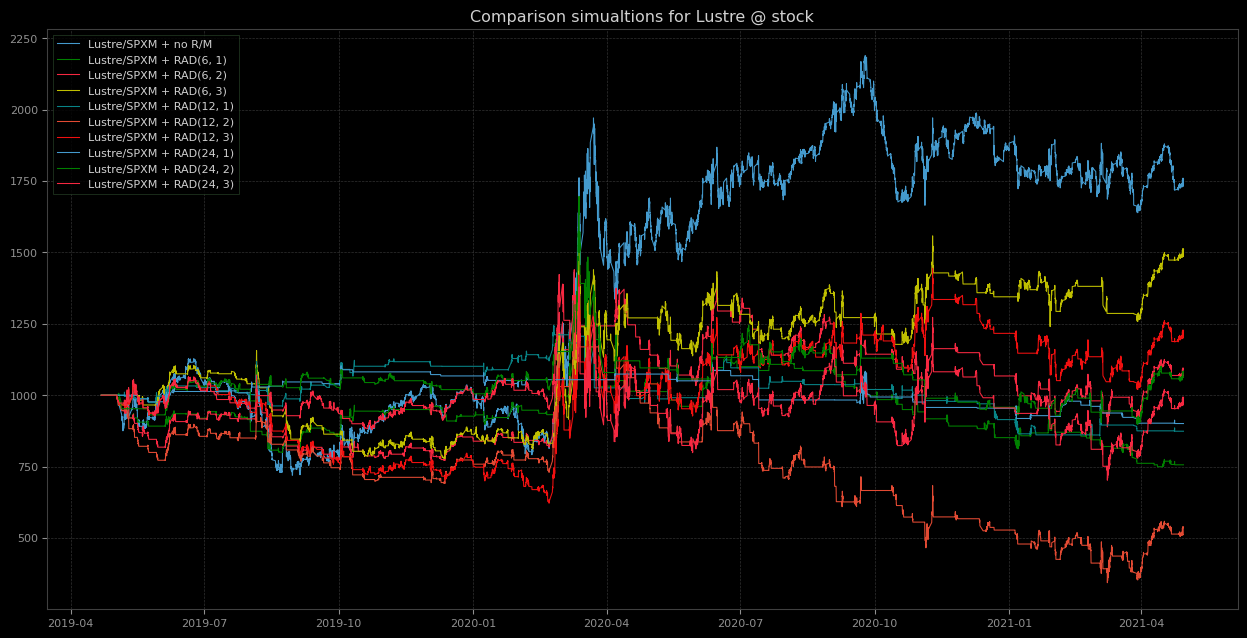

In [72]:
fig(16, 8)
spxm = run_simulations(l0_spxm, 1, md, spreads, 1000)


 0: Lustre/AUS200 + no R/M      : Sharpe: -inf | Sortino: -0.43 | CAGR: -41.36 | DD: $3856.20 (92.29%) | Gain: $-1819.20 | Execs: 214[OK]
 1: Lustre/AUS200 + RAD(6, 1)   : Sharpe: -inf | Sortino: -1.30 | CAGR: -44.41 | DD: $1138.80 (77.62%) | Gain: $-1069.20 | Execs: 479[OK]
 2: Lustre/AUS200 + RAD(6, 2)   : Sharpe: 0.32 | Sortino: 0.60 | CAGR: 5.41 | DD: $1874.00 (61.65%) | Gain: $168.10 | Execs: 470[OK]
 3: Lustre/AUS200 + RAD(6, 3)   : Sharpe: 0.61 | Sortino: 1.21 | CAGR: 16.77 | DD: $1179.90 (42.86%) | Gain: $579.60 | Execs: 350[OK]
 4: Lustre/AUS200 + RAD(12, 1)  : Sharpe: -inf | Sortino: -1.76 | CAGR: -59.31 | DD: $714.40 (70.54%) | Gain: $-1306.80 | Execs: 325[OK]
 5: Lustre/AUS200 + RAD(12, 2)  : Sharpe: 0.56 | Sortino: 1.20 | CAGR: 14.35 | DD: $1694.70 (54.49%) | Gain: $484.90 | Execs: 452[OK]
 6: Lustre/AUS200 + RAD(12, 3)  : Sharpe: -inf | Sortino: -0.46 | CAGR: -33.84 | DD: $2353.60 (87.94%) | Gain: $-994.20 | Execs: 402[OK]
 7: Lustre/AUS200 + RAD(24, 1)  : Sharpe: -inf |

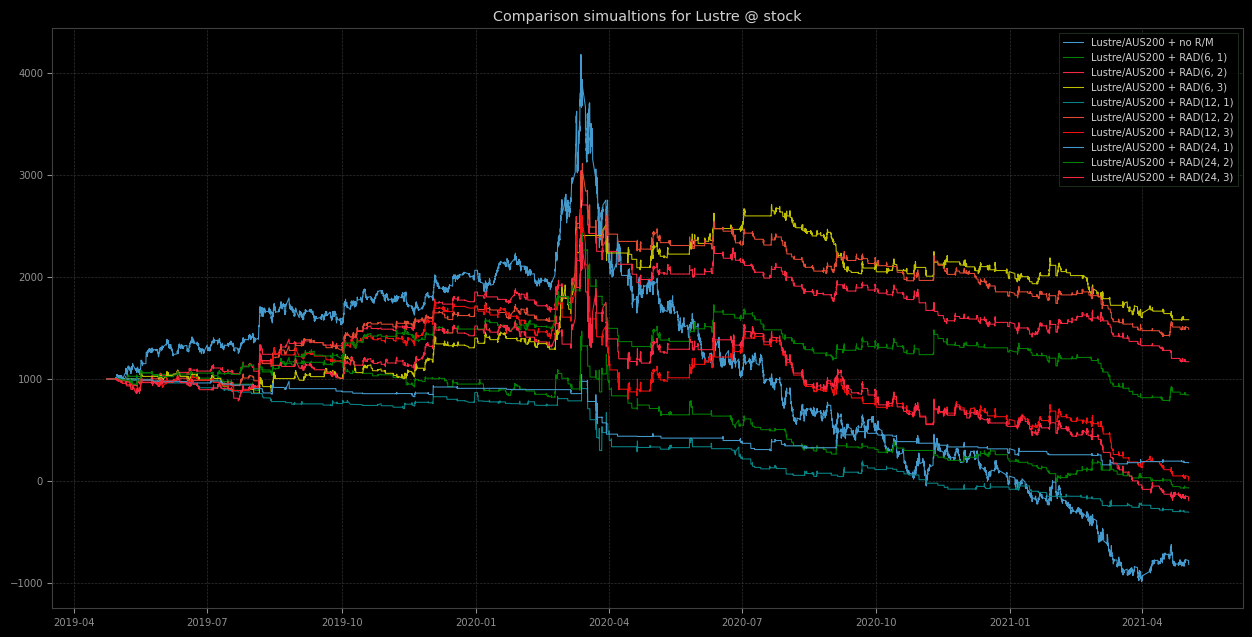

In [108]:
fig(16, 8)
aus = run_simulations(l0_aus, 1, md, spreads, 1000)


 0: Lustre/XTIUSD + no R/M      : Sharpe: -inf | Sortino: -4.62 | CAGR: -100.00 | DD: $901.00 (73.25%) | Gain: $755.00 | Execs: 102[OK]
 1: Lustre/XTIUSD + RAD(6, 1)   : Sharpe: 0.69 | Sortino: 2.05 | CAGR: 32.18 | DD: $951.00 (32.84%) | Gain: $1299.00 | Execs: 202[OK]
 2: Lustre/XTIUSD + RAD(6, 2)   : Sharpe: -inf | Sortino: -1.60 | CAGR: -91.62 | DD: $871.00 (72.58%) | Gain: $1100.00 | Execs: 174[OK]
 3: Lustre/XTIUSD + RAD(6, 3)   : Sharpe: -inf | Sortino: -3.14 | CAGR: -93.96 | DD: $839.00 (73.86%) | Gain: $991.00 | Execs: 138[OK]
 4: Lustre/XTIUSD + RAD(12, 1)  : Sharpe: 0.39 | Sortino: 0.99 | CAGR: 9.41 | DD: $1314.00 (55.40%) | Gain: $308.00 | Execs: 136[OK]
 5: Lustre/XTIUSD + RAD(12, 2)  : Sharpe: -inf | Sortino: -2.59 | CAGR: -96.81 | DD: $810.00 (71.30%) | Gain: $1143.00 | Execs: 152[OK]
 6: Lustre/XTIUSD + RAD(12, 3)  : Sharpe: 0.66 | Sortino: 1.33 | CAGR: 28.02 | DD: $1858.00 (48.00%) | Gain: $1090.00 | Execs: 126[OK]
 7: Lustre/XTIUSD + RAD(24, 1)  : Sharpe: 0.89 | Sorti

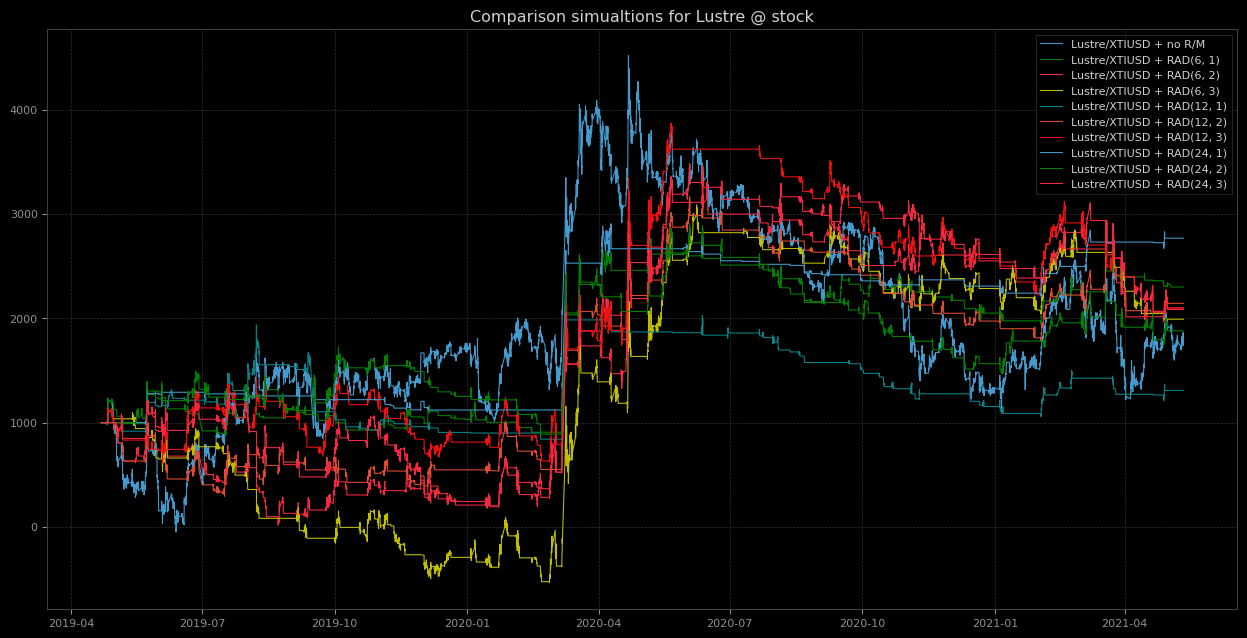

In [74]:
fig(16, 8)
xti = run_simulations(l0_xti, 100, md, spreads, 1000)

At glance all models produced profits during periods of strong trend and enough weak results on the rest.

Also we can note that period where we trained our models (<font color='red'>start_of_data : 2020-01-01</font>) doesn't include interval where markets showed significant price drop (<font color='red'>Feb'2020 : Mar'2020</font>).

As experiment we can try to train models including this period (let's say on interval <font color='red'>2019-10-01 : 2020-04-01</font>) and see if it may lead to any improve
<hr/>

In [79]:
l0_aus_F = run_grid_search(Lustre('1d', 12, 0.15, 50, 10), 'AUS200', md, ('2019-10-01', '2020-04-01'))
l0_spx_F = run_grid_search(Lustre('1d', 12, 0.15, 50, 10), 'SPXM', md,   ('2019-10-01', '2020-04-01'))
l0_xti_F = run_grid_search(Lustre('1d', 12, 0.15, 50, 10), 'XTIUSD', md, ('2019-10-01', '2020-04-01'))


 0: Lustre/SPXM + no R/M      : Sharpe: 1.01 | Sortino: 1.57 | CAGR: 34.77 | DD: $586.00 (25.52%) | Gain: $1413.40 | Execs: 125[OK]
 1: Lustre/SPXM + RAD(6, 1)   : Sharpe: 0.52 | Sortino: 0.90 | CAGR: 8.07 | DD: $157.70 (15.12%) | Gain: $257.50 | Execs: 445[OK]
 2: Lustre/SPXM + RAD(6, 2)   : Sharpe: 0.03 | Sortino: 0.05 | CAGR: -2.71 | DD: $413.90 (34.73%) | Gain: $-77.80 | Execs: 482[OK]
 3: Lustre/SPXM + RAD(6, 3)   : Sharpe: 0.01 | Sortino: 0.02 | CAGR: -6.08 | DD: $392.10 (35.45%) | Gain: $-169.00 | Execs: 447[OK]
 4: Lustre/SPXM + RAD(12, 1)  : Sharpe: 0.31 | Sortino: 0.55 | CAGR: 3.23 | DD: $231.30 (18.57%) | Gain: $98.40 | Execs: 308[OK]
 5: Lustre/SPXM + RAD(12, 2)  : Sharpe: 0.31 | Sortino: 0.51 | CAGR: 4.61 | DD: $272.60 (19.95%) | Gain: $142.30 | Execs: 467[OK]
 6: Lustre/SPXM + RAD(12, 3)  : Sharpe: -0.15 | Sortino: -0.23 | CAGR: -10.84 | DD: $765.50 (60.18%) | Gain: $-287.40 | Execs: 411[OK]
 7: Lustre/SPXM + RAD(24, 1)  : Sharpe: 0.80 | Sortino: 1.46 | CAGR: 8.95 | DD: 

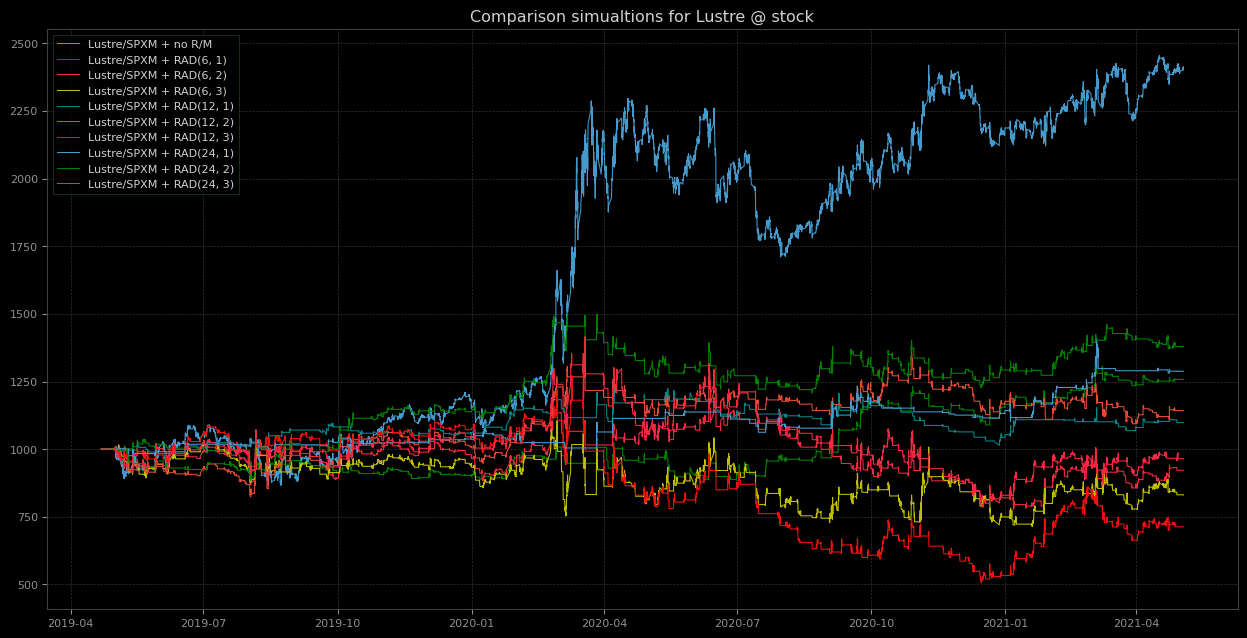

In [84]:
fig(16, 8)
spx_F = run_simulations(l0_spx_F, 1, md, spreads, 1000)


 0: Lustre/AUS200 + no R/M      : Sharpe: -inf | Sortino: -0.54 | CAGR: -45.31 | DD: $3623.70 (91.82%) | Gain: $-2878.90 | Execs: 242[OK]
 1: Lustre/AUS200 + RAD(6, 1)   : Sharpe: -inf | Sortino: -1.27 | CAGR: -52.10 | DD: $1023.70 (75.64%) | Gain: $-1557.00 | Execs: 550[OK]
 2: Lustre/AUS200 + RAD(6, 2)   : Sharpe: -0.18 | Sortino: -0.30 | CAGR: -14.30 | DD: $2195.70 (77.64%) | Gain: $-365.50 | Execs: 520[OK]
 3: Lustre/AUS200 + RAD(6, 3)   : Sharpe: 0.55 | Sortino: 1.06 | CAGR: 15.03 | DD: $1193.90 (44.24%) | Gain: $511.10 | Execs: 370[OK]
 4: Lustre/AUS200 + RAD(12, 1)  : Sharpe: -inf | Sortino: -2.07 | CAGR: -58.88 | DD: $710.10 (70.27%) | Gain: $-1433.20 | Execs: 340[OK]
 5: Lustre/AUS200 + RAD(12, 2)  : Sharpe: 0.53 | Sortino: 1.17 | CAGR: 14.06 | DD: $1639.50 (53.76%) | Gain: $473.90 | Execs: 508[OK]
 6: Lustre/AUS200 + RAD(12, 3)  : Sharpe: -inf | Sortino: -0.49 | CAGR: -33.14 | DD: $2204.10 (86.99%) | Gain: $-1070.50 | Execs: 427[OK]
 7: Lustre/AUS200 + RAD(24, 1)  : Sharpe: 

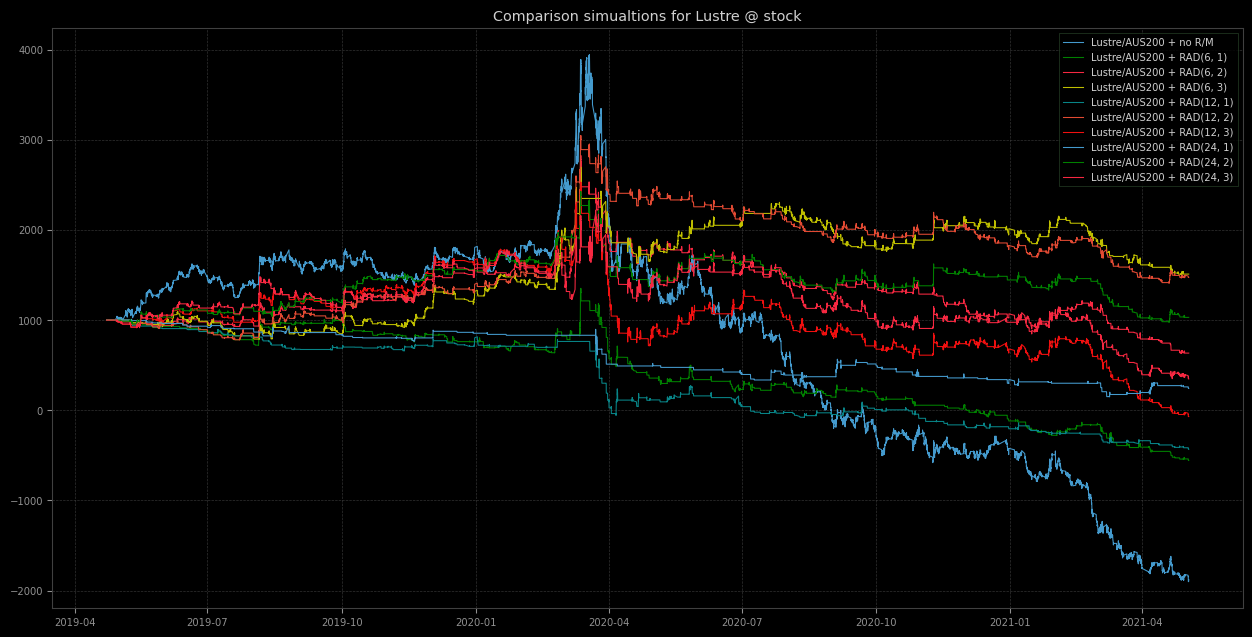

In [107]:
fig(16, 8)
aus_F = run_simulations(l0_aus_F, 1, md, spreads, 1000)


 0: Lustre/XTIUSD + no R/M      : Sharpe: 1.03 | Sortino: 1.71 | CAGR: 67.30 | DD: $2602.00 (38.63%) | Gain: $3673.00 | Execs: 202[OK]
 1: Lustre/XTIUSD + RAD(6, 1)   : Sharpe: -inf | Sortino: -0.77 | CAGR: -49.07 | DD: $1138.00 (78.97%) | Gain: $-2102.00 | Execs: 497[OK]
 2: Lustre/XTIUSD + RAD(6, 2)   : Sharpe: 0.82 | Sortino: 1.88 | CAGR: 44.76 | DD: $1006.00 (65.20%) | Gain: $2029.00 | Execs: 497[OK]
 3: Lustre/XTIUSD + RAD(6, 3)   : Sharpe: -inf | Sortino: -1.85 | CAGR: -91.36 | DD: $824.00 (71.78%) | Gain: $-1575.00 | Execs: 416[OK]
 4: Lustre/XTIUSD + RAD(12, 1)  : Sharpe: -inf | Sortino: -0.90 | CAGR: -35.67 | DD: $1152.00 (79.23%) | Gain: $-1108.00 | Execs: 327[OK]
 5: Lustre/XTIUSD + RAD(12, 2)  : Sharpe: 0.74 | Sortino: 1.80 | CAGR: 36.78 | DD: $1286.00 (35.86%) | Gain: $1556.00 | Execs: 497[OK]
 6: Lustre/XTIUSD + RAD(12, 3)  : Sharpe: 0.87 | Sortino: 1.82 | CAGR: 53.04 | DD: $1621.00 (35.06%) | Gain: $2578.00 | Execs: 443[OK]
 7: Lustre/XTIUSD + RAD(24, 1)  : Sharpe: -0.2

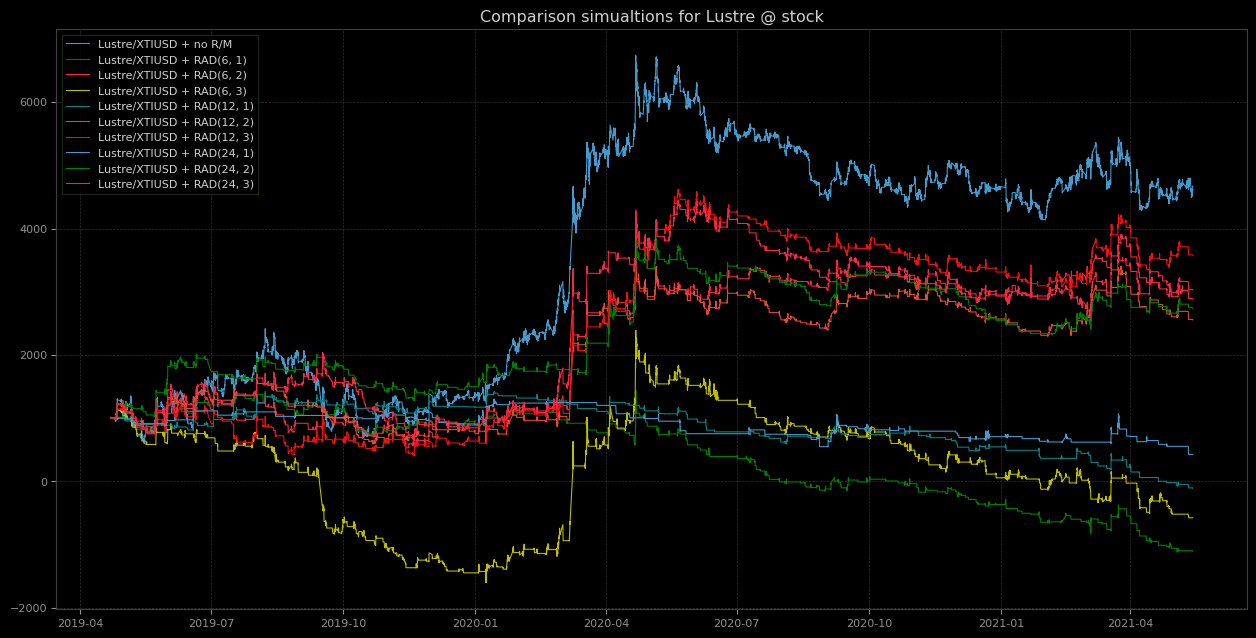

In [86]:
fig(16, 8)
xti_F = run_simulations(l0_xti_F, 100, md, spreads, 1000)

Now we can find performance of portofolio for all 3 instruments
<hr/>

In [109]:
spx_F.report.head(2)

,Name,sharpe,sortino,cagr,dd,dd_pct,gain,number_executions
0,Lustre/SPXM + no R/M,1.005099,1.574589,34.772179,586.0,25.515980,1413.4,125
7,"Lustre/SPXM + RAD(24, 1)",0.802462,1.464508,8.950585,131.7,10.675205,288.0,168


<p style='color:orange'>
For SPXM best strategy (highest Sharpe) was simple reversive model without any risk management.</br>
But it also has enough high drawdown (> 25%) so we will use model with risk management instead (#7).
</p>

In [120]:
aus_F.report.head(2)

,Name,sharpe,sortino,cagr,dd,dd_pct,gain,number_executions
3,"Lustre/AUS200 + RAD(6, 3)",0.550834,1.057523,15.029724,1193.9,44.239819,511.1,370
5,"Lustre/AUS200 + RAD(12, 2)",0.533931,1.170222,14.061360,1639.5,53.759386,473.9,508


In [169]:
xti_F.report.head(2)

,Name,sharpe,sortino,cagr,dd,dd_pct,gain,number_executions
0,Lustre/XTIUSD + no R/M,1.027746,1.708098,67.299337,2602.0,38.628266,3673.0,202
8,"Lustre/XTIUSD + RAD(24, 2)",0.940985,2.288907,40.011277,1639.0,41.451694,1741.0,387


<font size=2 color='orange'>Final tearsheet of Lustre model</font>
</hr>

In [122]:
pfl = scols(
    spx_F.r.results[7].get_portfolio(), 
    aus_F.r.results[3].get_portfolio(), 
    xti_F.r.results[8].get_portfolio())


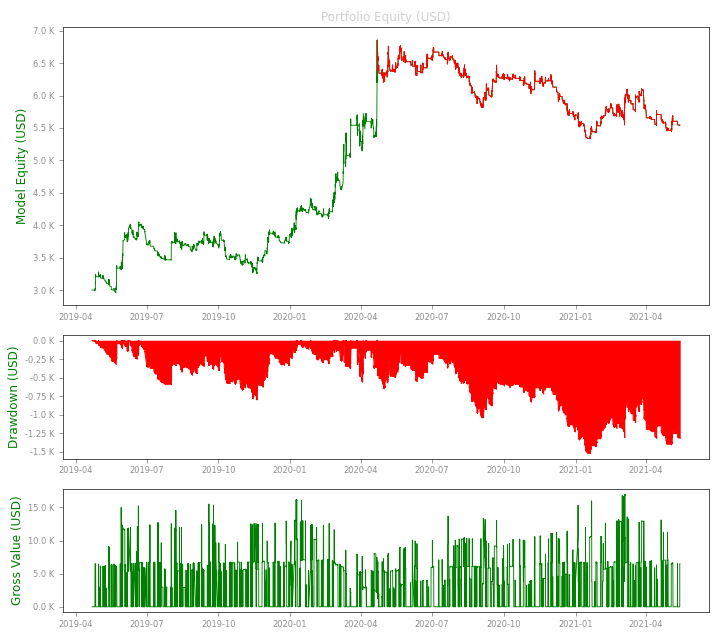

<Figure size 720x640 with 0 Axes>

In [123]:
tearsheet(pfl, 3000)

<font size=2>It's obvious that tuned model outperformed basic setup</font>

<hr/>
<font size=2 color='orange'>Comparison model to benchmark (SPY Buy & Hold strategy)</font>
<hr/>

Now we can see what if we just invested same deposit into trading of 1 contract of SPY ETF CFD (just bught 1 contract and hold it for whole period).


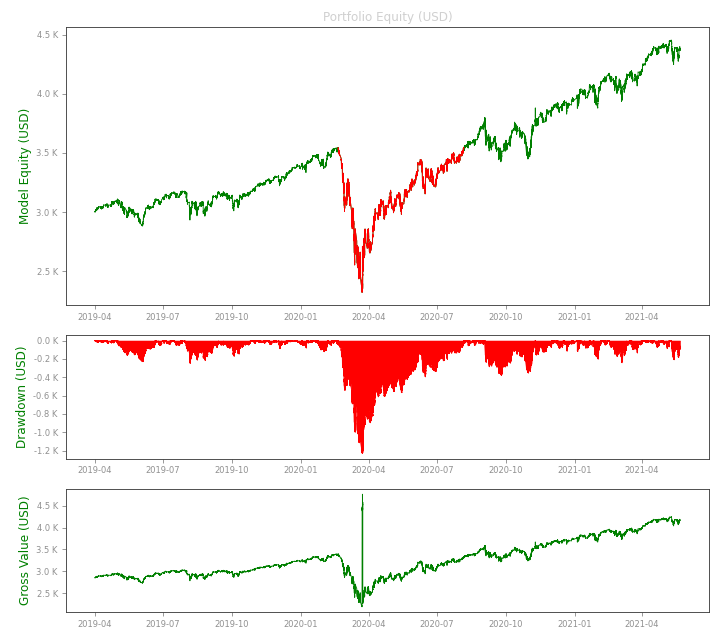

CAGR: 12.91%
              Returns    Balance
time                            
2019-04-30   3.450017  3103.5005
2019-05-31  -6.470113  2902.7005
2019-06-30   7.417231  3118.0005
2019-07-31   0.153945  3122.8005
2019-08-31  -1.629963  3071.9000
2019-09-30   1.975992  3132.6005
2019-10-31   1.758922  3187.7005
2019-11-30   3.350377  3294.5005
2019-12-31   2.719456  3384.0930
2020-01-31  -0.112157  3380.2975
2020-02-29  -7.608620  3123.1035
2020-03-31 -11.510698  2763.6125
2020-04-30  11.987878  3094.9110
2020-05-31   4.717082  3240.9005
2020-06-30   1.961770  3304.4795
2020-07-31   5.420506  3483.5990
2020-08-31   6.529913  3711.0750
2020-09-30  -3.437508  3583.5065
2020-10-31  -2.544700  3492.3170
2020-11-30  10.316589  3852.6050
2020-12-31   2.442542  3946.7065
2021-01-31  -1.274632  3896.4005
2021-02-28   3.983240  4051.6035
2021-03-31   3.507290  4193.7050
2021-04-30   4.945543  4401.1065
2021-05-31  -0.633795  4373.2125


<Figure size 720x640 with 0 Axes>

In [154]:
bench = benchmark_run('SPY', 3000, 1.5, '2019-04-01', report=1)

<hr/>
<font size=2 color='orange'>Compare monthly returns and cumulative equity for model and portfolio</font>
<hr/>

In [170]:
mon_rets_pfl = monthly_returns(pfl, 3000)
mon_rets_bmark = monthly_returns(bench, 3000)

pfl_stats = portfolio_stats(pfl, 3000)
bmark_stats = portfolio_stats(bench, 3000)
scols(mon_rets_pfl, mon_rets_bmark, keys=['Lustre strategy', 'SP500 Buy&Hold'])

CAGR: 22.72%
CAGR: 12.91%


Lustre strategy         SP500 Buy&Hold           
                   Returns Balance        Returns    Balance
2019-04-30        7.120000  3213.6       3.450017  3103.5005
2019-05-31       16.875156  3755.9      -6.470113  2902.7005
2019-06-30       -0.686919  3730.1       7.417231  3118.0005
2019-07-31       -7.080239  3466.0       0.153945  3122.8005
2019-08-31        6.168494  3679.8      -1.629963  3071.9000
2019-09-30        0.290777  3690.5       1.975992  3132.6005
2019-10-31       -7.310663  3420.7       1.758922  3187.7005
2019-11-30        5.715204  3616.2       3.350377  3294.5005
2019-12-31        6.819313  3862.8       2.719456  3384.0930
2020-01-31       10.815988  4280.6      -0.112157  3380.2975
2020-02-29        8.613279  4649.3      -7.608620  3123.1035
2020-03-31       13.853698  5293.4     -11.510698  2763.6125
2020-04-30       17.559603  6222.9      11.987878  3094.9110
2020-05-31        4.790371  6521.0       4.717082  3240.9005
2020-06-30        0.611869  6560.9       1.961770  3304.4795
2020-07-31       -1.614108  6455.0       5.420506  3483.5990
2020-08-31       -8.720372  5892.1       6.529913  3711.0750
2020-09-30        7.111217  6311.1      -3.437508  3583.5065
2020-10-31       -2.172363  6174.0      -2.544700  3492.3170
2020-11-30        1.022028  6237.1      10.316589  3852.6050
2020-12-31       -8.524795  5705.4       2.442542  3946.7065
2021-01-31       -3.016441  5533.3      -1.274632  3896.4005
2021-02-28        2.512063  5672.3       3.983240  4051.6035
2021-03-31        1.888123  5779.4       3.507290  4193.7050
2021-04-30       -5.490189  5462.1       4.945543  4401.1065
2021-05-31        1.428022  5540.1      -0.633795  4373.2125

We see that at months where SPY led to significant loses model outpreformed benchmark (Feb-Mar'2020).

<hr/>
<font size=2 color='orange'>Comparison of equity and monthly returns on chart</font>
<hr/>

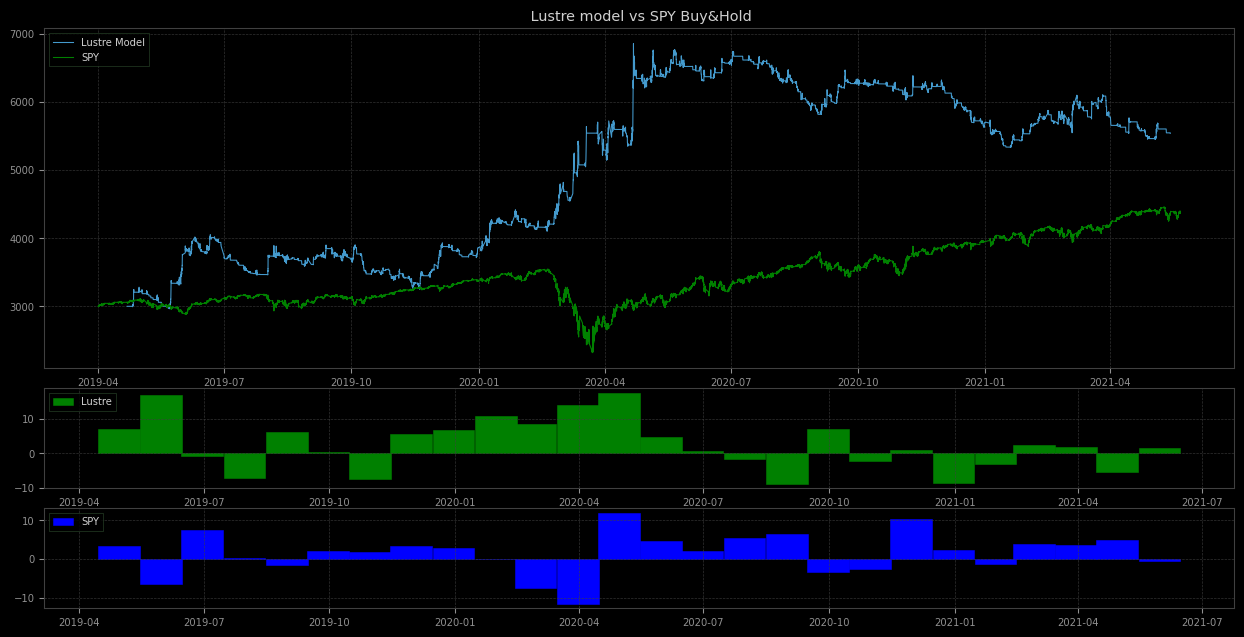

In [179]:
g = LookingGlass([
        pfl_stats['equity'].rename('Lustre Model'), 
        bmark_stats['equity'].rename('SPY')],
    {
    'Monthly Model': ['bar', 'green', mon_rets_pfl.Returns.rename('Lustre')],
    'Monthly Bench': ['bar', 'blue', mon_rets_bmark.Returns.rename('SPY')]})
fig(16, 8);  g.look(title='Lustre model vs SPY Buy&Hold');

<hr/>
<font size=2 color='orange'>Conclusions</font>
<hr/>

In general model demonstrates good results on trend periods and outperforms benchmark. On the other side it shows moderate performance on other periods.

<u>Need to consider</u>

    1. Try to increase winning positions (pyramiding)
    2. Think about other breakouts setups (levels breakouts for example)